<a href="https://colab.research.google.com/github/MasaAsami/modified_DMLDiD_RCS/blob/main/notebooks/Reproduction_of_DMLDiD_RCS_with_SIMDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://github.com/MasaAsami/modified_DMLDiD_RCS.git
#cd modified_DMLDiD_RCS
#cd notebooks

In [2]:
# title import pkg
import warnings

warnings.filterwarnings("ignore")

import sys
import os


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import (
    LogisticRegressionCV,
    LassoCV,
    Lasso,
    LogisticRegression,
)


sys.path.append(os.path.abspath("../"))
from dmldid.model_rcs import DMLDiD_RCS

from dmldid.simdata_genrater import generate_simdata_rcs, generate_simdata_rcs_fixX

# Verification with simulation data
## simulation data
-  repeated cross-section data
- true ATT := 3
- dim(X) := 10
- N = 500

In [3]:
df_rcs = generate_simdata_rcs_fixX(
    base_seed=1, N=500, Xcolumns_cnt=10, nonnull_x_cnt=3, true_att=3
)
df_rcs.head()

,unit_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,latent_group,latent_ps,D,Y,T
0,0,-9.158183,1.161933,-4.532897,-0.930350,-1.603513,-1.724936,12.394700,7.070890,-10.452273,-4.790106,0,0.9,0,39.009103,0
1,1,-3.828637,0.838513,-8.531369,-7.304513,3.296022,-1.154199,-8.826942,6.440126,0.611044,10.063201,0,0.9,0,46.126856,1
2,2,-6.398642,0.564814,-0.966379,3.116474,-2.249222,-13.965425,-4.981031,-1.365401,2.937855,6.069565,0,0.9,1,57.573361,0
3,3,-4.874784,0.839733,-8.429688,6.560939,7.819512,9.687644,-5.283466,5.637754,9.863194,-6.501527,0,0.9,0,40.649214,0
4,4,-4.776949,0.900822,-4.429587,1.324093,-5.327807,1.831660,-1.674586,-4.909411,-3.382856,9.890967,0,0.9,1,47.394932,0


## naive DiD

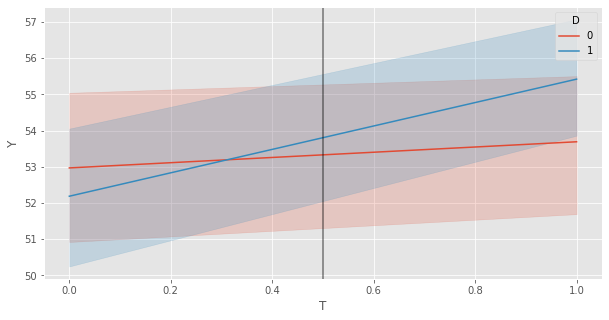

In [4]:
fig, ax = plt.subplots(1, 1, sharex="col", sharey="row", figsize=(10, 5))
sns.lineplot(x="T", y="Y", hue="D", data=df_rcs, ax=ax)
ax.axvline(x=0.5, alpha=0.5, color="black")
plt.show()

In [5]:
y_col = "Y"
d_col = "D"
t_col = "T"
X_cols = [col for col in df_rcs.columns if "x" in col]

# My solution:
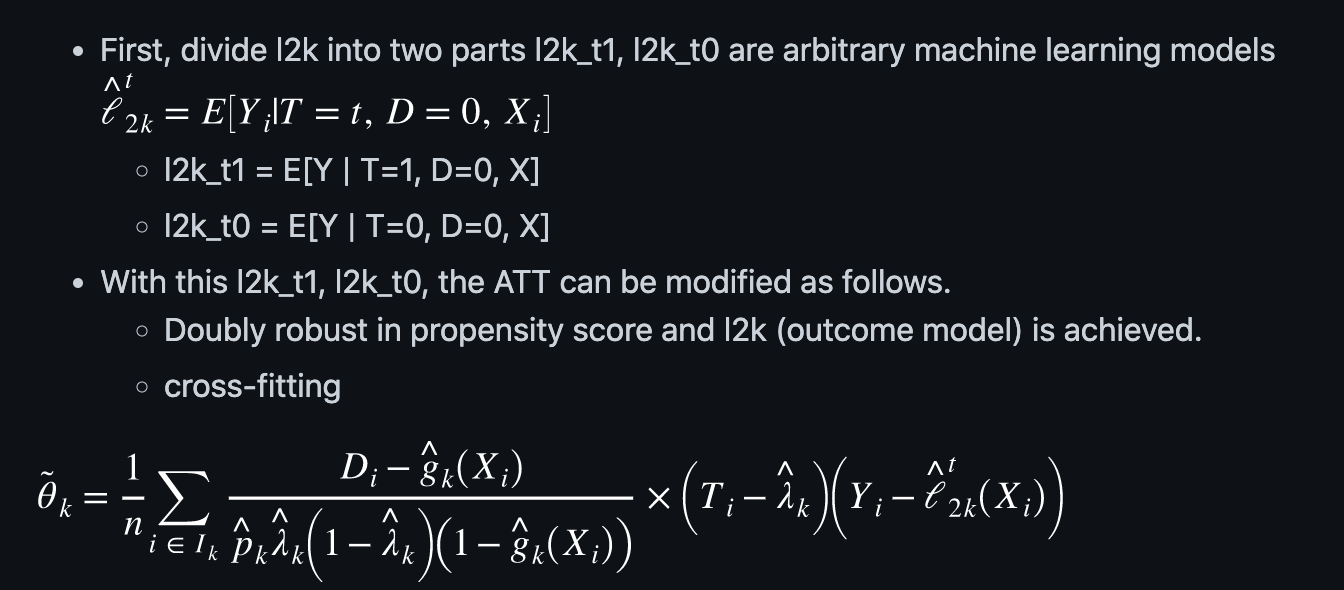

- linear_dmldid employs LogisticRegressionCV and LassoCV for l2k
- lgbm_dmldid employs LGBM for l2k

In [6]:
linear_dmldid = DMLDiD_RCS()

lgbm_dmldid = DMLDiD_RCS(
    d_model=LGBMClassifier(random_state=0),
    l2k_model=LGBMRegressor(random_state=0),
)

In [7]:
linear_dmldid.fit(
    df_rcs,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True,
)
algo_modified_bar = linear_dmldid.sim_att_result()

99. att :  2.957512545235049


In [8]:
lgbm_dmldid.fit(
    df_rcs,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True
)
algo_modified_bar_lgbm = lgbm_dmldid.sim_att_result()

99. att :  2.2337362713653013


# Chang(2020)
- This is a reproduction of the original DMLDID (Chang 2020) .
- It is implemented with a parameter that determines whether or not to correct an obvious implementation error.

In [9]:
def original_dmldid_rcs(
    df,
    y_col,
    d_col,
    t_col,
    X_cols,
    d_model=LogisticRegressionCV(cv=5, random_state=333, penalty="l1", solver="saga"),
    l2k_model=LassoCV(cv=5, random_state=333),
    original=True,
):
    B = 100
    K = 2  # ２分割

    thetabar = []

    for l in tqdm(range(B)):
        df_set = train_test_split(df, random_state=l, test_size=0.5)
        _thetabar = []
        for i in range(K):
            k = 0 if i == 0 else 1
            c = 1 if i == 0 else 0
            d_model.fit(df_set[c][X_cols], df_set[c][d_col])

            eps = 0.03
            if original and hasattr(d_model, "coef_"):
                z = df_set[k][X_cols] @ d_model.coef_.T
                ghat = 1 / (1 + np.exp(-1 * z))
            else:
                ghat = d_model.predict_proba(df_set[k][X_cols])[:, 1]

            cal_index = (eps <= ghat) & (ghat <= 1 - eps)

            ghat = np.clip(
                d_model.predict_proba(df_set[k][X_cols])[:, 1],
                eps,
                1 - eps,
            )

            lamda_hat = df_set[c][t_col].mean()
            if original:
                p_hat = df_set[k][d_col].mean()  # 本当はｃでは？
            else:
                p_hat = df_set[c][d_col].mean()

            control_y = df_set[c].query(f"{d_col} < 1")[y_col]
            control_t = df_set[c].query(f"{d_col} < 1")[t_col]
            control_x = df_set[c].query(f"{d_col} < 1")[X_cols]

            _y = (control_t - lamda_hat) * control_y

            l2k_model.fit(control_x, _y)

            if original and hasattr(l2k_model, "coef_"):
                l2k_hat = df_set[k][X_cols] @ l2k_model.coef_.T  # 間違い　切片が消えてる
            else:
                l2k_hat = l2k_model.predict(df_set[k][X_cols])

            _c = (
                ((df_set[k][t_col] - lamda_hat) * df_set[k][y_col] - l2k_hat)
                * (df_set[k][d_col] - ghat)
                / ((1 - ghat) * lamda_hat * (1 - lamda_hat) * p_hat)
            )


#             if original:
#                 _c = _c[cal_index]

            if original:
                _thetabar.append(_c[_c <= abs(_c.min())].mean())
            else:
                _thetabar.append(_c.mean())

        thetabar.append(np.mean(_thetabar))
    return thetabar

In [10]:
original_bar = original_dmldid_rcs(df_rcs, y_col, d_col, t_col, X_cols)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


In [11]:
original_bar_few_fixed = original_dmldid_rcs(
    df_rcs, y_col, d_col, t_col, X_cols, original=False
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.39it/s]


# Result :  modified DMLDiD  > original
- The modified model proposed in this notebook is more successful in reducing bias

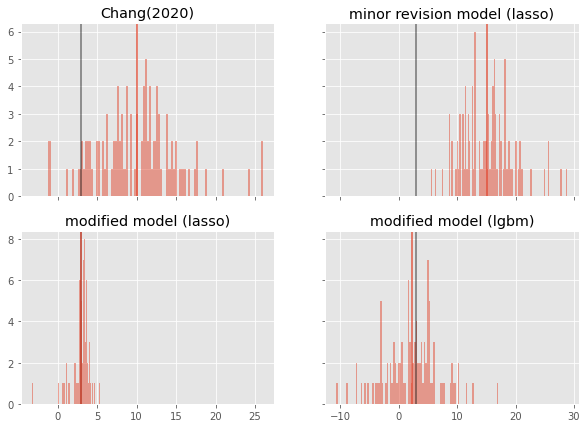

In [12]:
_label = [
    "Chang(2020)",
    "minor revision model (lasso)",
    "modified model (lasso)",
    "modified model (lgbm)",
]
result_df = pd.DataFrame(
    {
        "original_bar": original_bar,
        "few_fixed_bar": original_bar_few_fixed,
        "algo_modified_bar": algo_modified_bar,
        "algo_modified_bar_lgbm": algo_modified_bar_lgbm,
    }
)
fig, ax = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 7))
ax = ax.ravel()
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    # ax[i].set_xlim(0,5)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=3, alpha=0.5, color="black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

In [13]:
result_df.describe()

,original_bar,few_fixed_bar,algo_modified_bar,algo_modified_bar_lgbm
count,100.000000,100.000000,100.000000,100.000000
mean,10.070638,15.148150,2.958169,2.227825
std,5.144437,4.455313,1.132961,4.756312
min,-1.149547,5.510966,-3.219952,-10.649302
25%,6.708303,11.884348,2.597367,-0.747358
50%,10.147416,15.081239,3.067935,2.630222
75%,12.673704,17.722080,3.530150,5.048391
max,25.973534,28.824220,5.792103,17.025621


In [14]:
print("Done")

Done
